# Modelo Linear Regression
En este cuaderno se muestra cómo crear un modelo de TenserFlow basado de Regresión lineal, entrenar el modelo con datos para ver su capacidad de predicción de cómo sobreviven pasajeros del Titanic.



Instalación de tensorflow en el entorno virtual de python

In [ ]:
!pip install tensorflow

Comprobación de que el runtime tiene seleccionada la version 2.x de tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


Instalación de sklearn

In [ ]:
!pip install -q sklearn # instalación

librerías necesarias para usar regresión lineal

In [ ]:

from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

- Obtenemos datasets de tipo pandas (definido por el módulo pandas) a partir de ficheros csv

- Extraemos las que serán las columnas "label" de cada dataset(entrenamiento vs test/eval)

In [ ]:
dataTrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv') # training data, para entrenar al algoritmo
dataEval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv') # testing/evaluation data, para saber cómo de preciso es el algoritmo (regresión lineal en este caso)

# Extraemos la columna survived de ambos DataSet (tablas)
yesTrain = dataTrain.pop('survived')
yesEval = dataEval.pop('survived')

Generamos las "feature columns", resultado transformar campos con valores categóricos en valores enteros. Será necesario para crear el modelo de regresión más tarde

In [ ]:
categoricalColumns = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone'] # array de campos categorical del DataSet

numericColumns = ['age', 'fare'] # array de campos numéricos

featureColumns = [] # declaración

# bucle para generar feature columns a partir de "campos categóricos"
for featureName in categoricalColumns: # en featureName se almacenan todos los nombres de campos o columnas
  vocabulary = dataTrain[featureName].unique() # extraemos todos los valores únicos de cada columna
  featureColumns.append(tf.feature_column.sequence_categorical_column_with_vocabulary_list(featureName, vocabulary)) # va añadiendo al array feature columns, pasándole el nombre y los valores posibles

# bucle para generar feature columns a partir de "campos numéricos"
for featureName in numericColumns:
  featureColumns.append(tf.feature_column.numeric_column(featureName, dtype=tf.float32))

print(featureColumns)

[SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_column=VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), SequenceCategoricalColumn(categorical_co

- Creamos 2 funciones "input function" que son "recetas para cómo alimentar el modelo"
- train_input_fn y eval_input_fn son variables que almacenan funciones (cosas de python y de javascript)

In [ ]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dataTrain, yesTrain)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(dataEval, yesEval, num_epochs=1, shuffle=False)

Creamos el modelo a partir de las "feature columns"

In [ ]:
linearEstimator = tf.estimator.LinearClassifier(feature_columns=featureColumns) # Creamos el estimator (estimador basado en el modelo de regresión lineal) usando las feature columns que creamos antes a partir de los dataset

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmptkf1z9ax', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


- Entrenamos el modelo
- Guardamos el resultado de evaluar el modelo con la input function del dataset de test
- imprimimos la precisión

In [ ]:
linearEstimator.train(train_input_fn)  # la función que le pasamos como parámetro es la que entrena al modelo de la manera que hemos implementado antes
result = linearEstimator.evaluate(eval_input_fn)  # evaluamos el modelo una vez entrenado, con la otra input function (la de evaluacion)

clear_output() # limpia el log de la consola (información que no necesitamos)
print(result['accuracy']) # muestra el campo 'acuracy' del dictionary object 'result' que almacena estadísticas de la evaluación del modelo

0.75


Obtenemos un valor de precisión que queremos mejorar

In [ ]:
print(result) # vemos valores estadísticos de la evaluación del modelo entrenado

{'accuracy': 0.75, 'accuracy_baseline': 0.625, 'auc': 0.8233547, 'auc_precision_recall': 0.76298296, 'average_loss': 0.53557575, 'label/mean': 0.375, 'loss': 0.52643436, 'precision': 0.74626863, 'prediction/mean': 0.2660115, 'recall': 0.5050505, 'global_step': 200}


- Usamos el método predict() para analizar las probabilidades de supervivencia que arroja nuestro modelo y compararlos con la realidad
- predict() crea diccionarios

In [ ]:
pred_dicts = list(linearEstimator.predict(eval_input_fn)) # usamos predict() y le pasamos la input function de evaluacion
#print(pred_dicts) # diccionario de todas las predicciones
#print(pred_dicts[0]) # diccionario de la primera predicción
#print(pred_dicts[0]['probabilities']) # diccionario de la primera predicción usando la palabra 'probabilities' (que es lo que nos interesa)
#print(pred_dicts[0]['probabilities'][1]) # diccionario de la primera predicción, del campo probabilities, el segundo número (que es la probabilidad de supervivencia, mientras que el primer número es la probabilidad de no supervivencia)
print(dataEval.loc[0]) # loc imprime el elto localizdo en el índice 0 del dataset de pandas
print(pred_dicts[0]['probabilities'][1])



INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptkf1z9ax/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
sex                          male
age                            35
n_siblings_spouses              0
parch                           0
fare                         8.05
class                       Third
deck                      unknown
embark_town           Southampton
alone                           y
Name: 0, dtype: object
0.04136388


Otro ejemplo:

In [ ]:
print(dataEval.loc[2]) # loc imprime el elto localizdo en el índice 0 del dataset de pandas [datos reales]
print(yesEval.loc[2]) # del campo supervivencia del data set de evaluación [si sobrevive o no]
print(pred_dicts[2]['probabilities'][1]) # el registro 2 de los diccionarios de predicción [predicción de supervivencia]

# Vamos a poder ver si la predicción coincide con el valor real. Recuerda que nuestro modelo tiene sólo una accuracy de alrededor del 74%. Se podría cambiar el nº de epochs para obtener mayor accuracy.

sex                        female
age                            58
n_siblings_spouses              0
parch                           0
fare                        26.55
class                       First
deck                            C
embark_town           Southampton
alone                           y
Name: 2, dtype: object
1
0.433008


Representación usando pandas (no entiendo) para representar todos los valores predichos

INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1727: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptkf1z9ax/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


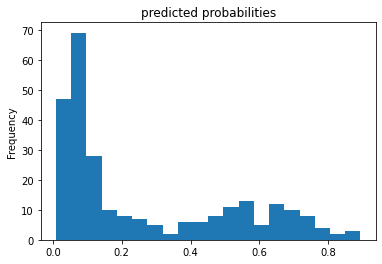

In [34]:
pred_dicts = list(linearEstimator.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')